#### Required libraries

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

#### 16-17 data preparation - train data

In [27]:
hr_16_17 = pd.read_excel('E:/DataSkills 2021/Imarticus DSP/Capstone Project/HR Analytics/staff utlz latest 16-17_masked.xlsx',header=[0,1]).reset_index()
hr_16_17.columns = ['-'.join(col).strip() for col in hr_16_17.columns.values]
hr_16_17.drop('index-',axis=1,inplace=True)

col_list = [a.split('-')[-1] for a in hr_16_17.columns]
col_list[0]='Employee No'

for i in range(115):
    hr_16_17.rename(columns={hr_16_17.columns[i]:col_list[i]},inplace=True)

hr_16_17_1 = hr_16_17.iloc[:,107:115]
hr_16_17_2 = hr_16_17.iloc[:,0:11]

hr_16_17_total = pd.concat([hr_16_17_2,hr_16_17_1],axis=1)

hr_16_17_total.loc[hr_16_17_total['Utilization%']=='-','Utilization%']=0
hr_16_17_total['Utilization%']=pd.to_numeric(hr_16_17_total['Utilization%'])

uti = hr_16_17_total.loc[hr_16_17_total['Utilization%'] < 2,'Utilization%'].max()
hr_16_17_total.loc[hr_16_17_total['Utilization%'] > 2,'Utilization%'] = uti

hr_16_17_total.loc[hr_16_17_total['Training Hours'] < 0,'Training Hours'] = 0
hr_16_17_total.loc[hr_16_17_total['BD Hours'] < 0,'BD Hours'] = 0
hr_16_17_total.loc[hr_16_17_total['NC Hours'] < 0,'NC Hours'] = 0

hr_16_17_total.loc[hr_16_17_total['Termination Date']=='-','Termination Date'] = pd.to_datetime('2017-03-31')
hr_16_17_total[['Join Date','Termination Date']]=hr_16_17_total[['Join Date','Termination Date']].apply(pd.to_datetime)
hr_16_17_total[['Join Date','Termination Date']]=hr_16_17_total[['Join Date','Termination Date']].apply(lambda t: t.dt.floor('d'))

hr_16_17_total['Tenure']=hr_16_17_total['Termination Date']-hr_16_17_total['Join Date']
hr_16_17_total['Tenure']=hr_16_17_total['Tenure'].dt.days
hr_16_17_total['Tenure'] = hr_16_17_total['Tenure']/365

# encoding 'Supervisor name' using count/frequency encoding
sv_name = hr_16_17_total['Supervisor name'].value_counts().to_dict()
hr_16_17_total['Supervisor name'] = hr_16_17_total['Supervisor name'].map(sv_name)

# Ordinal enconding of Employee Position feature
hr_16_17_total['Employee Position'].replace({'Level 7':7,'Level 8':8,'Level 6':6,'Level 5':5,'-':10,
                                             'Level 4':4,'Level 3':3,'Level 2':2,'Level A3':10,
                                             'Level A2':10,'Level 10':9,'Level 1':1,'Level A1':10},inplace=True)

# kepping only two employee Current Status
hr_16_17_total.loc[hr_16_17_total['Current Status']!='Resigned','Current Status']='Active'

# Encoding target feature (Current Status)
hr_16_17_total['Current Status'].replace({'Active':0,'Resigned':1},inplace=True)


#### further data pre-processing for train data

In [28]:
# this feature can be removed
hr_16_17_total['People Group'].value_counts()

Client Service Staff    781
Support Staff             8
Name: People Group, dtype: int64

#### Feature Selection

In [29]:
#pd.crosstab(hr_16_17_total['Profit Center'],hr_16_17_total['Current Status'])

from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(pd.crosstab(hr_16_17_total['Profit Center'],
                                                      hr_16_17_total['Current Status']))
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')
    

p value is 0.3349186846063238
Independent (H0 holds true)


In [30]:
#pd.crosstab(hr_16_17_total['Employee Location'],hr_16_17_total['Current Status'])

stat, p, dof, expected = chi2_contingency(pd.crosstab(hr_16_17_total['Employee Location'],
                                                      hr_16_17_total['Current Status']))
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.3329081521939553
Independent (H0 holds true)


Profit Center and Employee Location features can be removed

Found no prediction value in categorical-nominal features 

In [31]:
# removing unnecessary features
hr_16_17_total.drop(['Employee Name','People Group','Employee Location','Profit Center',
                     'Employee Category','Join Date','Termination Date'],inplace=True,axis=1)

<AxesSubplot:>

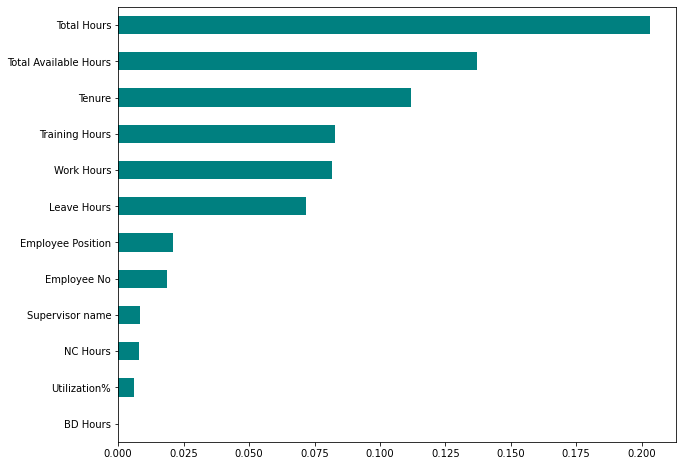

In [32]:
# Information Gain method
# feature selection by evaluating the Information gain of each variable in the context of the target variable

X = hr_16_17_total.drop('Current Status',axis=1)
y = hr_16_17_total['Current Status']
importance = mutual_info_classif(X,y)
plt.figure(figsize=(10,8));
feat_imp = pd.Series(importance,X.columns).sort_values()
feat_imp.plot(kind='barh',color='teal')

'BD Hours' feature can be removed

<AxesSubplot:>

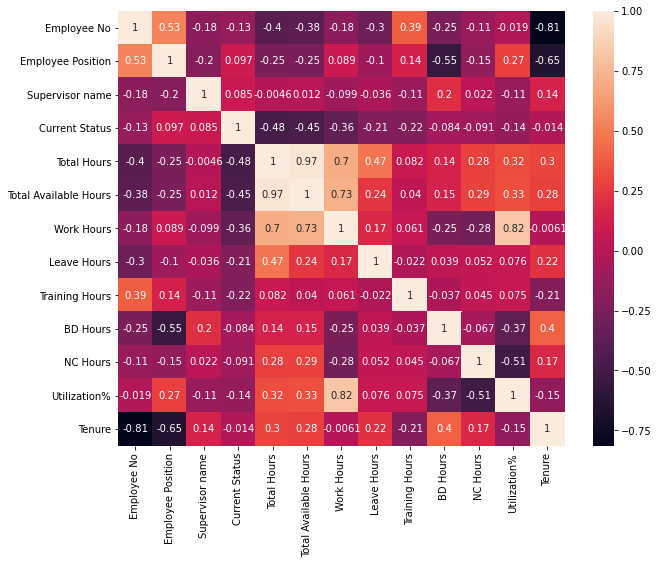

In [33]:
# Correlation matrix heatmap
plt.figure(figsize=(10,8));
sns.heatmap(hr_16_17_total.corr(),annot=True)

Correlation matrix heatmap - 'Total Hours' and 'Work Hours' features can be removed as these are redundant feature.

##### Final dataset for model building

In [34]:
hr_16_17_total.columns

Index(['Employee No', 'Employee Position', 'Supervisor name', 'Current Status',
       'Total Hours', 'Total Available Hours', 'Work Hours', 'Leave Hours',
       'Training Hours', 'BD Hours', 'NC Hours', 'Utilization%', 'Tenure'],
      dtype='object')

In [35]:
# scaling the numeric features
scaler = StandardScaler()
hr_16_17_scalled = scaler.fit_transform(hr_16_17_total[['Supervisor name','Total Available Hours','Leave Hours',
                                                        'Training Hours','NC Hours','Utilization%', 'Tenure']])

hr_16_17_for_model = pd.concat([hr_16_17_total['Employee Position'],
                                pd.DataFrame(hr_16_17_scalled),
                                hr_16_17_total['Current Status']],axis=1)

# 'Employee No' as index
hr_16_17_for_model.index = hr_16_17_total['Employee No']

# saving file to drive for model building
hr_16_17_for_model.to_csv('E:/DataSkills 2021/Imarticus DSP/Capstone Project/HR Analytics/hr_16_17_for_model.csv')

#### 17-18 data preparation - test data

In [51]:
hr_17_18 = pd.read_excel('E:/DataSkills 2021/Imarticus DSP/Capstone Project/HR Analytics/staff utlz latest 17-18_masked.xlsx',header=[0,1]).reset_index()

hr_17_18_1 = hr_17_18.iloc[:,108:116]
hr_17_18_2 = hr_17_18.iloc[:,0:12]
hr_17_18_total = pd.concat([hr_17_18_2,hr_17_18_1],axis=1)
#[hr_17_18.columns[i][0].strftime('%b-%Y') for i in range(12,108)]

hr_17_18_total.columns = ['-'.join(col).strip() for col in hr_17_18_total.columns.values]
hr_17_18_total.drop('index-',axis=1,inplace=True)

col_list = [a.split('-')[-1] for a in hr_17_18_total.columns]
col_list[0]='Employee No'

for i in range(19):
    hr_17_18_total.rename(columns={hr_17_18_total.columns[i]:col_list[i]},inplace=True)

#hr_17_18_1 = hr_17_18.iloc[:,107:115]
#hr_17_18_2 = hr_17_18.iloc[:,0:11]

# hr_17_18_total = pd.concat([hr_hr_17_18_2,hr_hr_17_18_1],axis=1)

hr_17_18_total['Termination Date'].fillna(value=pd.to_datetime('2018-03-31'),inplace=True)
hr_17_18_total[['Join Date','Termination Date']]=hr_17_18_total[['Join Date','Termination Date']].apply(pd.to_datetime)
hr_17_18_total[['Join Date','Termination Date']]=hr_17_18_total[['Join Date','Termination Date']].apply(lambda t: t.dt.floor('d'))

hr_17_18_total['Tenure']=hr_17_18_total['Termination Date']-hr_17_18_total['Join Date']
hr_17_18_total['Tenure']=hr_17_18_total['Tenure'].dt.days
hr_17_18_total['Tenure'] = hr_17_18_total['Tenure']/365

##### further data pre-processing for test data

In [52]:
hr_17_18_total.loc[hr_17_18_total['Utilization%']=='-','Utilization%']=0
hr_17_18_total['Utilization%']=pd.to_numeric(hr_17_18_total['Utilization%'])

hr_17_18_total.loc[hr_17_18_total['Current Status']!='Resigned','Current Status']='Active'
hr_17_18_total['Current Status'].replace({'Active':0,'Resigned':1},inplace=True)

hr_17_18_total['Employee Position'].value_counts()
hr_17_18_total['Employee Position'].replace({'Level 7':7,'Level 8':8,'Level 6':6,'Level 5':5,'-':10,
                                             'Level 4':4,'Level 3':3,'Level 2':2,'Level A3':10,
                                             'Level A2':10,'Level 10':9,'Level 1':1,'Level A1':10},inplace=True)

# encoding 'Supervisor name' using count/frequency encoding
sv_name2 = hr_17_18_total['Supervisor name'].value_counts().to_dict()
hr_17_18_total['Supervisor name'] = hr_17_18_total['Supervisor name'].map(sv_name2)

# scaling the numeric features
hr_17_18_scalled = scaler.fit_transform(hr_17_18_total[['Supervisor name','Total Available Hours','Leave Hours',
                                                        'Training Hours','NC Hours','Utilization%', 'Tenure']])

hr_17_18_for_model_testing = pd.concat([hr_17_18_total['Employee Position'],
                                        pd.DataFrame(hr_17_18_scalled),
                                        hr_17_18_total['Current Status']],axis=1)

# 'Employee No' as index
hr_17_18_for_model_testing.index = hr_17_18_total['Employee No']

# saving file to drive for model testing
hr_17_18_for_model_testing.to_csv('E:/DataSkills 2021/Imarticus DSP/Capstone Project/HR Analytics/hr_17_18_for_model_testing.csv')

##### Promotion data

In [55]:
hr_16_17_emp_pos = hr_16_17_for_model[['Employee Position']]
hr_17_18_emp_pos = hr_17_18_for_model_testing[['Employee Position']]

promotion = hr_16_17_emp_pos.join(hr_17_18_emp_pos,how='left',
                                  lsuffix='_old',rsuffix='_new')
#promotion.dropna(inplace=True)
promotion = promotion.astype(float,errors='ignore')
# promotion = promotion.loc[[promotion['Employee Position_old'] > promotion['Employee Position_new']],'promotion'] = 'promoted'

promotion['Employee Position_old'] > promotion['Employee Position_new']
# promotion['promotion']=''                                      
promotion['promotion'] = np.where(promotion['Employee Position_old'] > promotion['Employee Position_new'],1,0)

#promotion.loc[promotion['Employee Position_new'].isna(),'promotion'] = 2
#promotion['promotion'].value_counts()
promotion.dropna(inplace=True)
promotion.to_csv('E:/DataSkills 2021/Imarticus DSP/Capstone Project/HR Analytics/promotion.csv')
